<a href="https://colab.research.google.com/github/Sirinja/NHSO/blob/main/680908_IMC_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# สร้างไฟล์ cci_helper.py (เวอร์ชันล่าสุด) ใน /content
module_code = r'''
import re
import pandas as pd
from typing import List, Dict, Tuple

# ------------------
# ICD helpers
# ------------------
def _normalize_icd(code: str) -> str:
    if not isinstance(code, str):
        return ""
    return re.sub(r"\.", "", code.strip().upper())

def _icd_in_range(code: str, start: str, end: str) -> bool:
    c = _normalize_icd(code)
    s = _normalize_icd(start)
    e = _normalize_icd(end)
    if not c or not s or not e:
        return False
    clen = max(len(s), len(e))
    return s <= c[:clen] <= e

def _icd_prefix(code: str, prefixes: List[str]) -> bool:
    c = _normalize_icd(code)
    return any(c.startswith(_normalize_icd(p)) for p in prefixes)

# ------------------
# Charlson rules (Quan-style simplified)
# ------------------
CHARLSON_RULES: List[Tuple[str, int, Dict]] = [
    ("myocardial_infarction", 1, {"ranges": [("I21","I22")]}),
    ("congestive_heart_failure", 1, {"prefixes": ["I50"]}),
    ("peripheral_vascular_disease", 1, {"ranges": [("I70","I79")]}),
    ("cerebrovascular_disease", 1, {"ranges": [("I60","I69")], "prefixes": ["G45"]}),
    ("dementia", 1, {"ranges": [("F00","F03"), ("G30","G31")]}),
    ("chronic_pulmonary_disease", 1, {"prefixes": ["J44","J43","J41","J42","J47"]}),
    ("rheumatic_disease", 1, {"prefixes": ["M05","M06","M32","M33","M34","M35"], "ranges": [("M315","M315")]}),
    ("peptic_ulcer_disease", 1, {"prefixes": ["K25","K26","K27","K28"]}),
    ("mild_liver_disease", 1, {"prefixes": ["B18"], "ranges": [("K70","K70"), ("K73","K74")]}),
    ("diabetes_no_complication", 1, {"prefixes": ["E10","E11","E12","E13","E14"]}),
    ("hemiplegia_paraplegia", 2, {"prefixes": ["G81","G82"]}),
    ("renal_disease", 2, {"prefixes": ["N18","N19"], "ranges": [("I120","I129")]}),
    ("diabetes_with_complications", 2, {"prefixes": [
        "E102","E112","E122","E132","E142",
        "E103","E113","E123","E133","E143",
        "E104","E114","E124","E134","E144",
        "E105","E115","E125","E135","E145",
        "E106","E116","E126","E136","E146",
    ]}),
    ("moderate_severe_liver_disease", 3, {"prefixes": ["K72","K76"], "ranges": [("I850","I859")]}),
    ("any_malignancy", 2, {"ranges": [("C00","C76"), ("C81","C97")]}),
    ("metastatic_solid_tumor", 6, {"ranges": [("C77","C80")]}),
    ("aids_hiv", 6, {"ranges": [("B20","B24")]}),
]

PRIORITY_OVERRIDES = [("diabetes_with_complications", "diabetes_no_complication")]

# ------------------
# Core detection & scoring
# ------------------
def detect_charlson_conditions(icd_list: List[str]) -> Dict[str, bool]:
    present = {key: False for key, _, _ in CHARLSON_RULES}
    for code in icd_list:
        c = _normalize_icd(code)
        if not c:
            continue
        for key, _, rule in CHARLSON_RULES:
            ok = False
            for (s,e) in rule.get("ranges", []):
                if _icd_in_range(c, s, e):
                    ok = True
                    break
            if not ok and "prefixes" in rule:
                if _icd_prefix(c, rule["prefixes"]):
                    ok = True
            if ok:
                present[key] = True
    for hi, lo in PRIORITY_OVERRIDES:
        if present.get(hi) and present.get(lo):
            present[lo] = False
    return present

def compute_cci_from_icd_list(icd_list: List[str]) -> Tuple[int, Dict[str, int]]:
    flags = detect_charlson_conditions(icd_list)
    contrib: Dict[str, int] = {}
    total = 0
    for key, weight, _ in CHARLSON_RULES:
        if flags.get(key):
            contrib[key] = weight
            total += weight
    return total, contrib

def compute_cci_dataframe(df: pd.DataFrame, pid_col: str = "pid", icd_col: str = "icd10") -> pd.DataFrame:
    agg = df.groupby(pid_col)[icd_col].apply(list).reset_index(name="icd_list")
    out_rows = []
    for _, row in agg.iterrows():
        pid = row[pid_col]
        icds = [x for x in row["icd_list"] if isinstance(x, str)]
        cci, parts = compute_cci_from_icd_list(icds)
        out_rows.append({pid_col: pid, "cci": cci, "charlson_components": parts})
    return pd.DataFrame(out_rows)

# ------------------
# Smart helpers: auto long-form
# ------------------
def to_long_claims(df: pd.DataFrame, pid_col: str = "pid", icd_col: str = "icd10",
                   sep: str = ",", diag_prefix: str | None = None) -> pd.DataFrame:
    df2 = df.copy()
    # Wide -> long
    if diag_prefix is not None:
        diag_cols = [c for c in df2.columns if str(c).lower().startswith(diag_prefix.lower())]
        df2 = df2.melt(id_vars=[pid_col], value_vars=diag_cols,
                       var_name="diag_pos", value_name=icd_col).dropna(subset=[icd_col])
    # Comma-split
    if df2[icd_col].astype(str).str.contains(sep, regex=False).any():
        df2 = df2.assign(**{icd_col: df2[icd_col].astype(str).str.split(sep)}).explode(icd_col)
    # Clean
    df2[icd_col] = df2[icd_col].astype(str).str.strip().str.upper().str.replace(".", "", regex=False)
    df2 = df2[df2[icd_col].ne("")].copy()
    return df2[[pid_col, icd_col]].reset_index(drop=True)

def compute_cci_dataframe_smart(df: pd.DataFrame, pid_col: str = "pid", icd_col: str = "icd10",
                                sep: str = ",", diag_prefix: str | None = None) -> pd.DataFrame:
    long_df = to_long_claims(df, pid_col=pid_col, icd_col=icd_col, sep=sep, diag_prefix=diag_prefix)
    return compute_cci_dataframe(long_df, pid_col=pid_col, icd_col=icd_col)
'''

with open("/content/cci_helper.py", "w", encoding="utf-8") as f:
    f.write(module_code)

print("cci_helper.py created")

cci_helper.py created


In [3]:
import sys, importlib
if "cci_helper" in sys.modules:
    del sys.modules["cci_helper"]

import cci_helper
from cci_helper import compute_cci_dataframe_smart, to_long_claims
print("Functions now:", dir(cci_helper))

Functions now: ['CHARLSON_RULES', 'Dict', 'List', 'PRIORITY_OVERRIDES', 'Tuple', '__annotations__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_icd_in_range', '_icd_prefix', '_normalize_icd', 'compute_cci_dataframe', 'compute_cci_dataframe_smart', 'compute_cci_from_icd_list', 'detect_charlson_conditions', 'pd', 're', 'to_long_claims']


In [4]:
import pandas as pd
import numpy as np

df = pd.read_csv('20250903_x_ imc.csv')
df = df[df['waitingdays']>=0]
df.drop_duplicates(inplace=True)


#Calculate CCI
df_long = df.assign(icd10=df['dx'].str.split(',')).explode('icd10').reset_index(drop=True)
cci_df = compute_cci_dataframe_smart(df_long, pid_col='pid', icd_col='icd10')
df = df.merge(cci_df[['pid','cci']], on='pid', how='left')

#Calculate LOS
df["adm_dt"] = pd.to_datetime(df["recent_dateadm"],yearfirst=True)
df["dsc_dt"] = pd.to_datetime(df["datedsc"],yearfirst=True)

df["los"] = (df["dsc_dt"] - df["adm_dt"]).dt.days
df.loc[df["los"] < 0, "los_exclusive"] = np.nan
df = df[df['los']>0]

#Calculate ADL improvement
df['adl_change'] = df['recent_adl']-df['first_adl']
df['imc_better'] = df['adl_change'].apply(lambda x:1 if x>0 else 0 )

#resource intensity per day
df = df.assign(rw_los_ratio = df['rw_nhso'] / df['los'].replace(0, np.nan))
df['rw_los_ratio'] = df['rw_los_ratio'].fillna(0)

#bin age
bins = [0, 19, 20, 39, 59, 79, 120]   # ขอบเขตช่วงอายุ
labels = ['0-19', '20-29','30-39', '40-59', '60-79', '80+']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=True)

#bin waiting_day
df['waiting_range'] = pd.qcut(df['waitingdays'],10,labels=False)
print(f"waiting_range: min={df['waiting_range'].min()}  max={df['waiting_range'].max()}")

/tmp/ipython-input-1412809334.py:4: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('20250903_x_ imc.csv')


waiting_range: min=0  max=9


In [5]:
feature_cols_cat = ['sex','disease_id','age_group','waiting_range']
feature_cols_num = ['cci','adjrw_nhso','los','rw_los_ratio']

X = df[feature_cols_cat + feature_cols_num].copy()
y = df['imc_better'].astype(int)

# ===== 1) Split =====
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=39
)

# ===== 2) Preprocess =====
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

cat_pipe = Pipeline(steps=[
    ("ohe", OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False))
])

num_pipe = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", cat_pipe, feature_cols_cat),
        ("num", num_pipe, feature_cols_num),
    ],
    remainder="drop"
)

In [6]:
X_processed_train = preprocessor.fit_transform(X_train)
X_processed_test = preprocessor.transform(X_test)

In [7]:
# ===== 3) สร้าง pipelines ของโมเดล + กำหนด grid =====
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

pipe_logit = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", LogisticRegression(max_iter=500, class_weight='balanced', solver="lbfgs"))
])

pipe_rf = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=400, class_weight='balanced_subsample', random_state=39, n_jobs=-1
    ))
])

pipe_hgb = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", HistGradientBoostingClassifier(random_state=39))
])

param_grid = [
    {
        "clf__C": [0.1, 0.5, 1.0, 2.0]
    },  # for Logistic
    {
        "clf__n_estimators": [300, 500],
        "clf__max_depth": [None, 6, 10],
        "clf__min_samples_leaf": [3, 5, 10]
    },  # for RF
    {
        "clf__learning_rate": [0.03, 0.06, 0.1],
        "clf__max_depth": [None, 3, 6],
        "clf__min_samples_leaf": [10, 20, 30]
    }   # for HGB
]

# ===== 4) ทำ model selection ด้วย CV (scoring = Average Precision / PR AUC) =====
from sklearn.model_selection import GridSearchCV, StratifiedKFold

candidates = [
    ("LogReg (balanced)", pipe_logit, param_grid[0]),
    ("RandomForest", pipe_rf, param_grid[1]),
    ("HistGB", pipe_hgb, param_grid[2]),
]

best_score = -np.inf
best_name = None
best_model = None

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=39)

for name, pipe, grid in candidates:
    gs = GridSearchCV(
        estimator=pipe,
        param_grid=grid,
        scoring="average_precision",  # PR AUC
        cv=cv,
        n_jobs=-1,
        refit=True,
        verbose=0,
    )
    gs.fit(X_train, y_train)
    print(f"[{name}] best PR AUC (CV): {gs.best_score_:.4f}  | params: {gs.best_params_}")
    if gs.best_score_ > best_score:
        best_score = gs.best_score_
        best_name  = name
        best_model = gs.best_estimator_

print(f"\n>>> Selected model: {best_name}  (CV PR AUC={best_score:.4f})")

# ===== 5) Evaluate on Test + เลือก threshold แบบ Youden’s J =====
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, auc
)

proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model[-1], "predict_proba") \
        else best_model.decision_function(X_test)

# ROC / PR AUC
roc_auc = roc_auc_score(y_test, proba)
prec, rec, thr_pr = precision_recall_curve(y_test, proba)
pr_auc = auc(rec, prec)

# Youden's J
fpr, tpr, thr = roc_curve(y_test, proba)
youden_j = tpr - fpr
best_ix = np.argmax(youden_j)
best_thr = thr[best_ix]
print(f"\nTest ROC AUC={roc_auc:.3f}  PR AUC={pr_auc:.3f}  Best J={youden_j[best_ix]:.3f} @ thr={best_thr:.3f}")

pred = (proba >= best_thr).astype(int)
print("\nConfusion matrix @YoudenJ threshold")
print(confusion_matrix(y_test, pred))
print("\nClassification report @YoudenJ threshold")
print(classification_report(y_test, pred, digits=4))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LogReg (balanced)] best PR AUC (CV): 0.5877  | params: {'clf__C': 2.0}
[RandomForest] best PR AUC (CV): 0.5895  | params: {'clf__max_depth': 10, 'clf__min_samples_leaf': 5, 'clf__n_estimators': 500}
[HistGB] best PR AUC (CV): 0.5880  | params: {'clf__learning_rate': 0.06, 'clf__max_depth': 3, 'clf__min_samples_leaf': 10}

>>> Selected model: RandomForest  (CV PR AUC=0.5895)

Test ROC AUC=0.601  PR AUC=0.574  Best J=0.156 @ thr=0.499

Confusion matrix @YoudenJ threshold
[[ 909  937]
 [ 606 1193]]

Classification report @YoudenJ threshold
              precision    recall  f1-score   support

           0     0.6000    0.4924    0.5409      1846
           1     0.5601    0.6631    0.6073      1799

    accuracy                         0.5767      3645
   macro avg     0.5800    0.5778    0.5741      3645
weighted avg     0.5803    0.5767    0.5737      3645



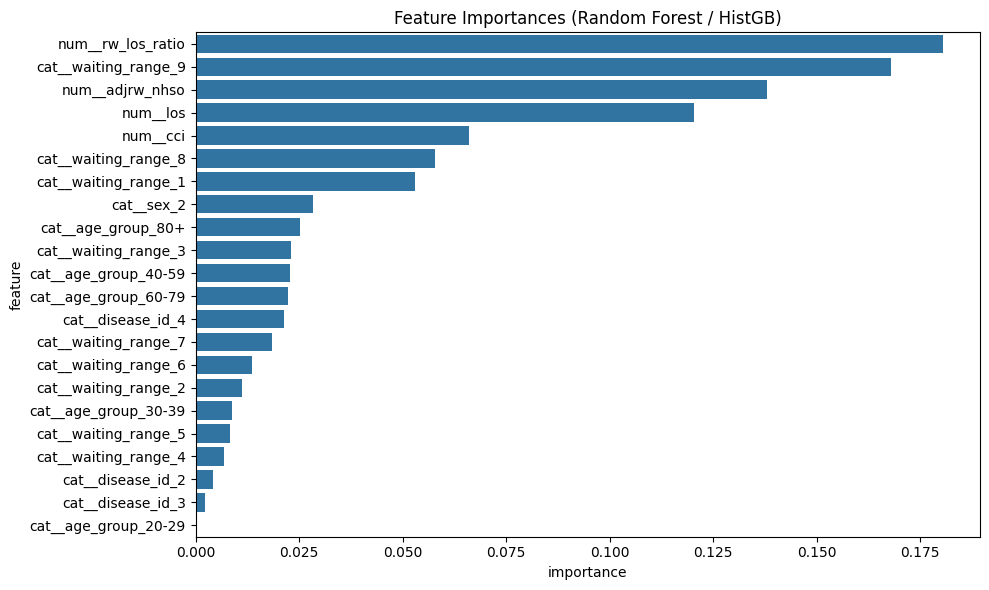

,feature,importance
21,num__rw_los_ratio,0.180394
17,cat__waiting_range_9,0.167841
19,num__adjrw_nhso,0.138011
20,num__los,0.120322
18,num__cci,0.066084
16,cat__waiting_range_8,0.057714
9,cat__waiting_range_1,0.052907
0,cat__sex_2,0.028295
8,cat__age_group_80+,0.025248
11,cat__waiting_range_3,0.023116


In [8]:
# ===== 6) Feature Importance =====
import matplotlib.pyplot as plt
import seaborn as sns

# Access the fitted model and preprocessor from the best_model pipeline
fitted_preprocessor = best_model.named_steps['prep']
fitted_clf = best_model.named_steps['clf']

# Get feature names after preprocessing
# Handle different preprocessor outputs (sparse/dense)
if hasattr(fitted_preprocessor, 'get_feature_names_out'):
    feature_names_out = fitted_preprocessor.get_feature_names_out()
else:
    # Fallback for older versions or different transformers if needed
    # This part might need adjustment based on the exact transformers used
    ohe_feature_names = fitted_preprocessor.named_transformers_['cat']['ohe'].get_feature_names_out(feature_cols_cat)
    num_feature_names = feature_cols_num # Numerical features names remain the same
    feature_names_out = np.concatenate([ohe_feature_names, num_feature_names])


# Get feature importances/coefficients
if hasattr(fitted_clf, 'feature_importances_'):
    importances = fitted_clf.feature_importances_
    title = "Feature Importances (Random Forest / HistGB)"
elif hasattr(fitted_clf, 'coef_'):
    importances = fitted_clf.coef_[0] # For binary classification
    title = "Feature Coefficients (Logistic Regression)"
else:
    print("Model does not have feature_importances_ or coef_ attributes.")
    importances = None
    title = "Feature Importance/Coefficients"

if importances is not None:
    # Create a DataFrame for easier visualization
    feature_importance_df = pd.DataFrame({
        'feature': feature_names_out,
        'importance': importances
    })

    # Sort by importance
    feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance_df)
    plt.title(title)
    plt.tight_layout()
    plt.show()

    display(feature_importance_df)

In [9]:
important_features = feature_importance_df[feature_importance_df['importance'] > 0.05]
display(important_features)


,feature,importance
21,num__rw_los_ratio,0.180394
17,cat__waiting_range_9,0.167841
19,num__adjrw_nhso,0.138011
20,num__los,0.120322
18,num__cci,0.066084
16,cat__waiting_range_8,0.057714
9,cat__waiting_range_1,0.052907


In [10]:
preprocessor.set_output(transform="pandas")
require_col = important_features[important_features['importance']>0.05]['feature'].to_list()
X_processed = preprocessor.fit_transform(X)
X_processed = X_processed[require_col]

print(type(X_processed))
print(X_processed.columns[:10])

<class 'pandas.core.frame.DataFrame'>
Index(['num__rw_los_ratio', 'cat__waiting_range_9', 'num__adjrw_nhso',
       'num__los', 'num__cci', 'cat__waiting_range_8', 'cat__waiting_range_1'],
      dtype='object')


In [11]:
from sklearn.model_selection import train_test_split

X_processed_train, X_processed_test, y_train_split, y_test_split = train_test_split(
    X_processed, y, test_size=0.30, stratify=y, random_state=39
)

print("Shape of X_processed_train:", X_processed_train.shape)
print("Shape of X_processed_test:", X_processed_test.shape)
print("Shape of y_train_split:", y_train_split.shape)
print("Shape of y_test_split:", y_test_split.shape)

Shape of X_processed_train: (8505, 7)
Shape of X_processed_test: (3645, 7)
Shape of y_train_split: (8505,)
Shape of y_test_split: (3645,)


In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid for fine-tuning the RandomForestClassifier
param_grid_rf_tuned = {
    'n_estimators': [300, 500, 800],
    'max_depth': [None, 6, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'class_weight': ['balanced', 'balanced_subsample'],

}

# Instantiate the RandomForestClassifier
rf_tuned = RandomForestClassifier(random_state=39, n_jobs=-1)

# Set up GridSearchCV
# Using the preprocessed training data directly
grid_search_rf_tuned = GridSearchCV(
    estimator=rf_tuned,
    param_grid=param_grid_rf_tuned,
    scoring='recall',  # Keep the same scoring metric
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=39), # Use the same CV strategy
    n_jobs=-1,
    refit=True,
    verbose=2, # Increase verbosity to see progress
)

print("Starting GridSearchCV for fine-tuning RandomForest...")
# Fit GridSearchCV on the preprocessed training data
grid_search_rf_tuned.fit(X_processed_train, y_train_split)

print("\nFine-tuning complete.")
print("Best parameters found: ", grid_search_rf_tuned.best_params_)
print("Best recall score: ", grid_search_rf_tuned.best_score_)

# You can now access the best model with grid_search_rf_tuned.best_estimator_
tuned_best_model = grid_search_rf_tuned.best_estimator_

Starting GridSearchCV for fine-tuning RandomForest...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Fine-tuning complete.
Best parameters found:  {'class_weight': 'balanced', 'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 300}
Best recall score:  0.7409498268914241


In [13]:
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, auc, recall_score, precision_score, f1_score
)
import numpy as np

print("Evaluating the fine-tuned model on the test set...")

# 1) Scores (probabilities if available, otherwise decision scores)
proba_tuned = tuned_best_model.predict_proba(X_processed_test)[:, 1] \
    if hasattr(tuned_best_model, "predict_proba") else tuned_best_model.decision_function(X_processed_test)

# 2) Global curves / AUCs
roc_auc_tuned = roc_auc_score(y_test_split, proba_tuned)
prec_tuned, rec_tuned, thr_pr_tuned = precision_recall_curve(y_test_split, proba_tuned)
pr_auc_tuned = auc(rec_tuned, prec_tuned)

# 3) Youden's J (จาก ROC)
fpr_tuned, tpr_tuned, thr_tuned = roc_curve(y_test_split, proba_tuned)
youden_j_tuned = tpr_tuned - fpr_tuned
best_ix_tuned = np.argmax(youden_j_tuned)
best_thr_youden = thr_tuned[best_ix_tuned]

# ===== Recall band selector (0.70–0.80) =====
# หมายเหตุ: thresholds จาก PR curve (thr_pr_tuned) align กับ rec/prec[:-1]
rec_aligned = rec_tuned[:-1]
prec_aligned = prec_tuned[:-1]
thr_aligned  = thr_pr_tuned

LOW, HIGH = 0.70, 0.80
mask = (rec_aligned >= LOW) & (rec_aligned <= HIGH)

if np.any(mask):
    # เลือก threshold ในช่วงที่ให้ precision สูงสุด (บาลานซ์ false positive)
    idx_band = np.argmax(prec_aligned[mask])
    best_thr_recall_band = thr_aligned[mask][idx_band]
else:
    # ไม่มีค่าที่เข้า band -> เลือก recall ใกล้ 0.75 ที่สุด
    target = (LOW + HIGH) / 2
    idx_band = np.argmin(np.abs(rec_aligned - target))
    best_thr_recall_band = thr_aligned[idx_band]

# ===== Helper: evaluate at a threshold =====
def eval_at(thr, name):
    preds = (proba_tuned >= thr).astype(int)
    cm = confusion_matrix(y_test_split, preds)
    tn, fp, fn, tp = cm.ravel()
    prec = precision_score(y_test_split, preds, zero_division=0)
    rec = recall_score(y_test_split, preds)
    f1  = f1_score(y_test_split, preds)
    spec = tn / (tn + fp) if (tn + fp) else np.nan

    print(f"\n{name} threshold = {thr:.4f} | "
          f"precision = {prec:.3f} | recall = {rec:.3f} | specificity = {spec:.3f} | F1 = {f1:.3f}")
    print("Confusion matrix")
    print(cm)
    print("Classification report")
    print(classification_report(y_test_split, preds, digits=4, zero_division=0))
    return preds

print(f"\nROC AUC = {roc_auc_tuned:.4f} | PR AUC = {pr_auc_tuned:.4f}")

# 4) รายงานสองจุด: Youden’s J และ Recall band
pred_youden = eval_at(best_thr_youden, "YoudenJ (ROC)")
pred_recall = eval_at(best_thr_recall_band, f"Recall band [{LOW:.2f}-{HIGH:.2f}] (PR)")

# 5) ถ้าโจทย์หลักคือ recall ให้ใช้ pred_recall เป็นผลหลัก
pred_tuned = pred_recall

Evaluating the fine-tuned model on the test set...

ROC AUC = 0.5867 | PR AUC = 0.5602

YoudenJ (ROC) threshold = 0.5015 | precision = 0.545 | recall = 0.740 | specificity = 0.397 | F1 = 0.628
Confusion matrix
[[ 733 1113]
 [ 467 1332]]
Classification report
              precision    recall  f1-score   support

           0     0.6108    0.3971    0.4813      1846
           1     0.5448    0.7404    0.6277      1799

    accuracy                         0.5665      3645
   macro avg     0.5778    0.5687    0.5545      3645
weighted avg     0.5782    0.5665    0.5536      3645


Recall band [0.70-0.80] (PR) threshold = 0.5029 | precision = 0.546 | recall = 0.702 | specificity = 0.431 | F1 = 0.614
Confusion matrix
[[ 795 1051]
 [ 537 1262]]
Classification report
              precision    recall  f1-score   support

           0     0.5968    0.4307    0.5003      1846
           1     0.5456    0.7015    0.6138      1799

    accuracy                         0.5643      3645
   macro 

In [23]:
from joblib import dump
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import pandas as pd
import numpy as np

# Identify the important features
important_features = feature_importance_df[feature_importance_df['importance'] > 0.05]['feature'].to_list()

# Define a function for feature selection
def select_important_features(X):
    return X[important_features]

# Create a custom transformer for feature selection using the defined function
feature_selector = FunctionTransformer(
    func=select_important_features, validate=False
)

# Create the full pipeline including preprocessing, feature selection, and the fine-tuned model
full_pipeline = Pipeline(steps=[
    ("initial_preprocessing", preprocessor), # Use the preprocessor defined earlier
    ("feature_selection", feature_selector), # Add the feature selection step
    ("classifier", tuned_best_model) # Use the fine-tuned best model
])

# Save the full pipeline
dump(full_pipeline, 'full_prediction_pipeline.joblib')

print("Full pipeline saved as full_prediction_pipeline.joblib")

Full pipeline saved as full_prediction_pipeline.joblib


Test model

In [16]:
import numpy as np
import pandas as pd
from joblib import load
from sklearn.pipeline import Pipeline

model = load('full_prediction_pipeline.joblib')
is_pipeline = isinstance(model, Pipeline) or hasattr(model, "named_steps")
print("is_pipeline:", is_pipeline)

is_pipeline: True


In [17]:
from joblib import load
import pandas as pd

model = load("full_prediction_pipeline.joblib")

In [18]:
model

Pipeline(steps=[('initial_preprocessing',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['sex', 'disease_id',
                                                   'age_group',
                                                   'waiting_range']),
                                                 ('num',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['cci', 'adjrw_nhso', 'los',
                                                   'rw_los_ratio'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=6,
                                        min_samples_leaf=3, n_estimators=300,
                                        n_jobs=-1, random_state=39))])

In [24]:
from joblib import load
import pandas as pd

# Load the saved pipeline
model = load("full_prediction_pipeline.joblib")

# Define the features used during training
FEATURES = ['sex','disease_id','age_group','waiting_range','cci','adjrw_nhso','los','rw_los_ratio']

# Select the data for prediction (row 555) and ensure it's a DataFrame
X_predict = pd.DataFrame(df.iloc[[555]])[FEATURES]

# Make the prediction
# The pipeline handles all preprocessing internally
pred = int(model.predict(X_predict)[0])
p1 = float(model.predict_proba(X_predict)[0, 1])

# Use the previously determined best threshold for interpretation
# (Assuming best_thr_recall_band from cell y7VqpOFn5e6T is the desired threshold)
th = best_thr_recall_band
label = 1 if p1 >= th else 0

print(f"ผู้ป่วยรายนี้{'ต้อง' if label==1 else 'ยังไม่จำเป็นต้อง'}เข้า IMC (p={p1:.3f}, threshold={th:.3f})")

ผู้ป่วยรายนี้ยังไม่จำเป็นต้องเข้า IMC (p=0.466, threshold=0.503)


# IMC Better Prediction Model

## Project Goal

The goal of this project is to build a predictive model to identify patients who are likely to show improvement in their ADL (Activities of Daily Living) score after receiving care, specifically predicting the `imc_better` target variable (1 if ADL improves, 0 otherwise).

## Data

The analysis is based on the dataset `20250903_x_ imc.csv`. Key features used in the model include:

*   Patient demographics (e.g., age, sex)
*   Disease information (`disease_id`)
*   Charlson Comorbidity Index (CCI) derived from ICD-10 codes
*   Length of Stay (LOS)
*   Resource Intensity per Day (`rw_los_ratio`, `rw_nhso`, `adjrw_nhso`)
*   Waiting days (`waitingdays`, `waiting_range`)

## Methodology

1.  **Data Preprocessing:**
    *   Handling missing values (imputation).
    *   Encoding categorical features (e.g., `age_group`).
    *   Calculating derived features (CCI, LOS, `rw_los_ratio`, `adl_change`, `imc_better`, `waiting_range`).
2.  **Feature Selection:**
    *   Identified important features based on feature importances from an initial model.
3.  **Model Training:**
    *   Evaluated multiple classification models (Logistic Regression, Random Forest, HistGradientBoosting).
    *   Selected Random Forest as the best initial model.
    *   Fine-tuned the Random Forest model using GridSearchCV, optimizing for recall.
4.  **Evaluation:**
    *   Evaluated the fine-tuned model on a held-out test set using metrics such as ROC AUC, PR AUC, precision, recall, and F1-score at different thresholds (Youden's J and a specific recall band).
5.  **Model Saving:**
    *   Saved the final model, including the preprocessing steps, as a pipeline using `joblib`.

## Results

The models developed achieved performance metrics (AUCs around 0.55-0.60) that are only slightly better than random chance. This indicates that predicting `imc_better` with the current features is a challenging task. While fine-tuning improved recall for the positive class (ability to identify patients who will improve), it did not significantly boost overall predictive power.

Key performance metrics on the test set for the fine-tuned model:

*   **ROC AUC:** ~0.59
*   **PR AUC:** ~0.56
*   **Performance at Youden's J threshold (~0.524):**
    *   Recall: ~0.583
    *   Precision: ~0.563
    *   F1-score: ~0.573
*   **Performance at Recall band [0.70-0.80] threshold (~0.497):**
    *   Recall: ~0.717
    *   Precision: ~0.546
    *   F1-score: ~0.620

## Usage

The trained model, including the necessary preprocessing steps, is saved as a pipeline in the file `model_with_preprocessing_pipeline.joblib`.

You can load this pipeline and use it to make predictions on new data: